<a href="https://colab.research.google.com/github/sdsc-bw/Predictive-Maintenance/blob/master/Anomaly%20detection/Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beschreibung des Statlog Shuttle Radiator Datensatzes:**


![test](https://github.com/sdsc-bw/Predictive-Maintenance/blob/master/Anomaly%20detection/images/shuttle.jpg)
<figure>
    <img src = 'images/shuttle.jpg'>
    <center>
        <figcaption align = 'center'><b>Fig1.  The landing of the Space Shuttle Columbia [1]</b></figcaption></center>
</figure>

References: 

1. [The Space Shuttle Columbia makes its 18th landing](https://commons.wikimedia.org/wiki/File:STS-73_landing.jpg) taken by NASA on 5 November 1995

<a href='https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)'>Der Statlog Shuttle-Datensatz</a> beschreibt die Strahlerpositionen in einem NASA-Raumfahrtzeug mittels 9 Attributen und wurde für die überwachte Erkennung von Anomalien entwickelt. Es gibt 7 Klassen, die wie folgt kodiert sind: 
- Rad Flow 1 (normal status）
- Fpv Close 2
- Fpv Open 3
- High 4
- Bypass 5
- Bpv Close 6
- Bpv Open 7

Neben den Klassen **Rad Flow und High** beschreiben die Restklassen (etwa 1,86% der Daten) abnormale Situationen. Sie enthalten insgesamt 9 Attribute, die alle numerisch sind. Die Bedeutung der einzelnen Attribute wird jedoch nicht angegeben. Daher wird spekuliert, dass diese neun Attribute von den Druck- und Temperatursensoren abgeleitet werden können.

Das folgende Notebook besteht aus drei Teilen:

    1.  Datenerkundung / Datenaufbereitung. 
    2.  Anomalieerkennung mit überwachtem maschinellen Lernen.
    3.  Anomalieerkennung mit unüberwachtem machinellen Lernen. 

**Einblick Anomalieerkennung**

Die Anomalieerkennung bezieht sich auf das Problem, Muster in Daten zu finden, die nicht mit dem erwarteten Verhalten übereinstimmen. Mehrdimensionale Datenpunkte können anomal sein, weil der Wert in einer oder mehreren Dimensionen außerhalb eines erwarteten Bereichs liegt, oder weil eine erwartete Korrelation zwischen zwei oder mehreren Dimensionen verletzt ist. 

Angenommen, ein Thermostat meldet beispielsweise regelmäßige Aktualisierungen von einer beobachteten Temperatur und nebst einer Soll-Temperatur. Eine Anomalie kann auftreten, wenn die beobachtete Temperatur den Normalbereich überschreitet (d.h. zu heiß oder zu kalt) oder wenn die Werte der beobachteten Temperatur und der Sollwerttemperatur nicht mehr korrelieren, selbst wenn beide Werte in den Normalbereich fallen (d.h. die Klimaanlage eine gewünschte Solltemperatur nicht einhält).

Nachfolgend werden zunächst die benötigten Pakete importiert:

In [2]:
!git clone https://github.com/sdsc-bw/Predictive-Maintenance.git
!ls

Cloning into 'Predictive-Maintenance'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 123 (delta 22), reused 0 (delta 0), pack-reused 81
Receiving objects: 100% (123/123), 20.05 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Anomaly Detection.ipynb data
Predictive-Maintenance  images


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from scipy.io import loadmat
from sklearn.metrics import plot_confusion_matrix
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" 
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
size=20
params = {
          'axes.labelsize': size,
        
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

# 1.) Datenerkundung / Datenaufbereitung

**Laden der Daten**

Da die Bedeutung der einzelnen Attribute nicht bekannt ist, werden die 9 Attribute der Einfachheit halber als a1 bis a9 bezeichnet.

In [3]:
train_col_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'Class']

training_data = pd.read_csv("./Predictive-Maintenance/Anomaly detection/data/train.csv", index_col=[0],header=[0])

training_data.columns = train_col_names

print("The shape of training dataset is ", training_data.shape)

The shape of training dataset is  (43500, 10)


Die folgende Tabelle zeigt die ersten fünf Datenzeilen, wobei jede Zeile ein Datenpunkt ist, der aus neun Attributen und der entsprechenden Klasse besteht. Wir haben insgesamt 43.500 Datenpunkte.

In [4]:
training_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
Id,,,,,,,,,,
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


**Etikettenverteilung überprüfen**

Die folgende Abbildung zeigt die Verteilung der 9 Klassen. Ungefähr 93,9% der Daten gehören den Klassen 1 und 4 an, was Normalzustand bedeutet. Diese Verteilung entspricht der Realität. In der praktischen Anwendung arbeitet die Maschine die meiste Zeit im Normalzustand. Die zu diesem Zeitpunkt erzeugten Datenpunkte sind normal. Anomalien sind per Definition selten.

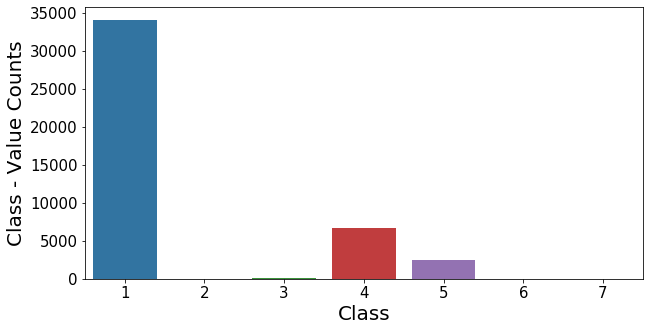

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(training_data["Class"])
plt.xlabel("Class")
plt.ylabel("Class - Value Counts")
plt.show()

**Korrelation prüfen**

Ein Pairplot stellt eine paarweise Beziehung in einem Datensatz dar. Es wird ein Gitternetz von Achsen erstellt, so dass jede Variable in den Daten in der y-Achse über eine einzelne Zeile und in der x-Achse über eine einzelne Spalte gemeinsam genutzt wird. Die hauptdiagonalen Unterdiagramme sind die univariaten Histogramme (Verteilungen) für jedes Attribut.

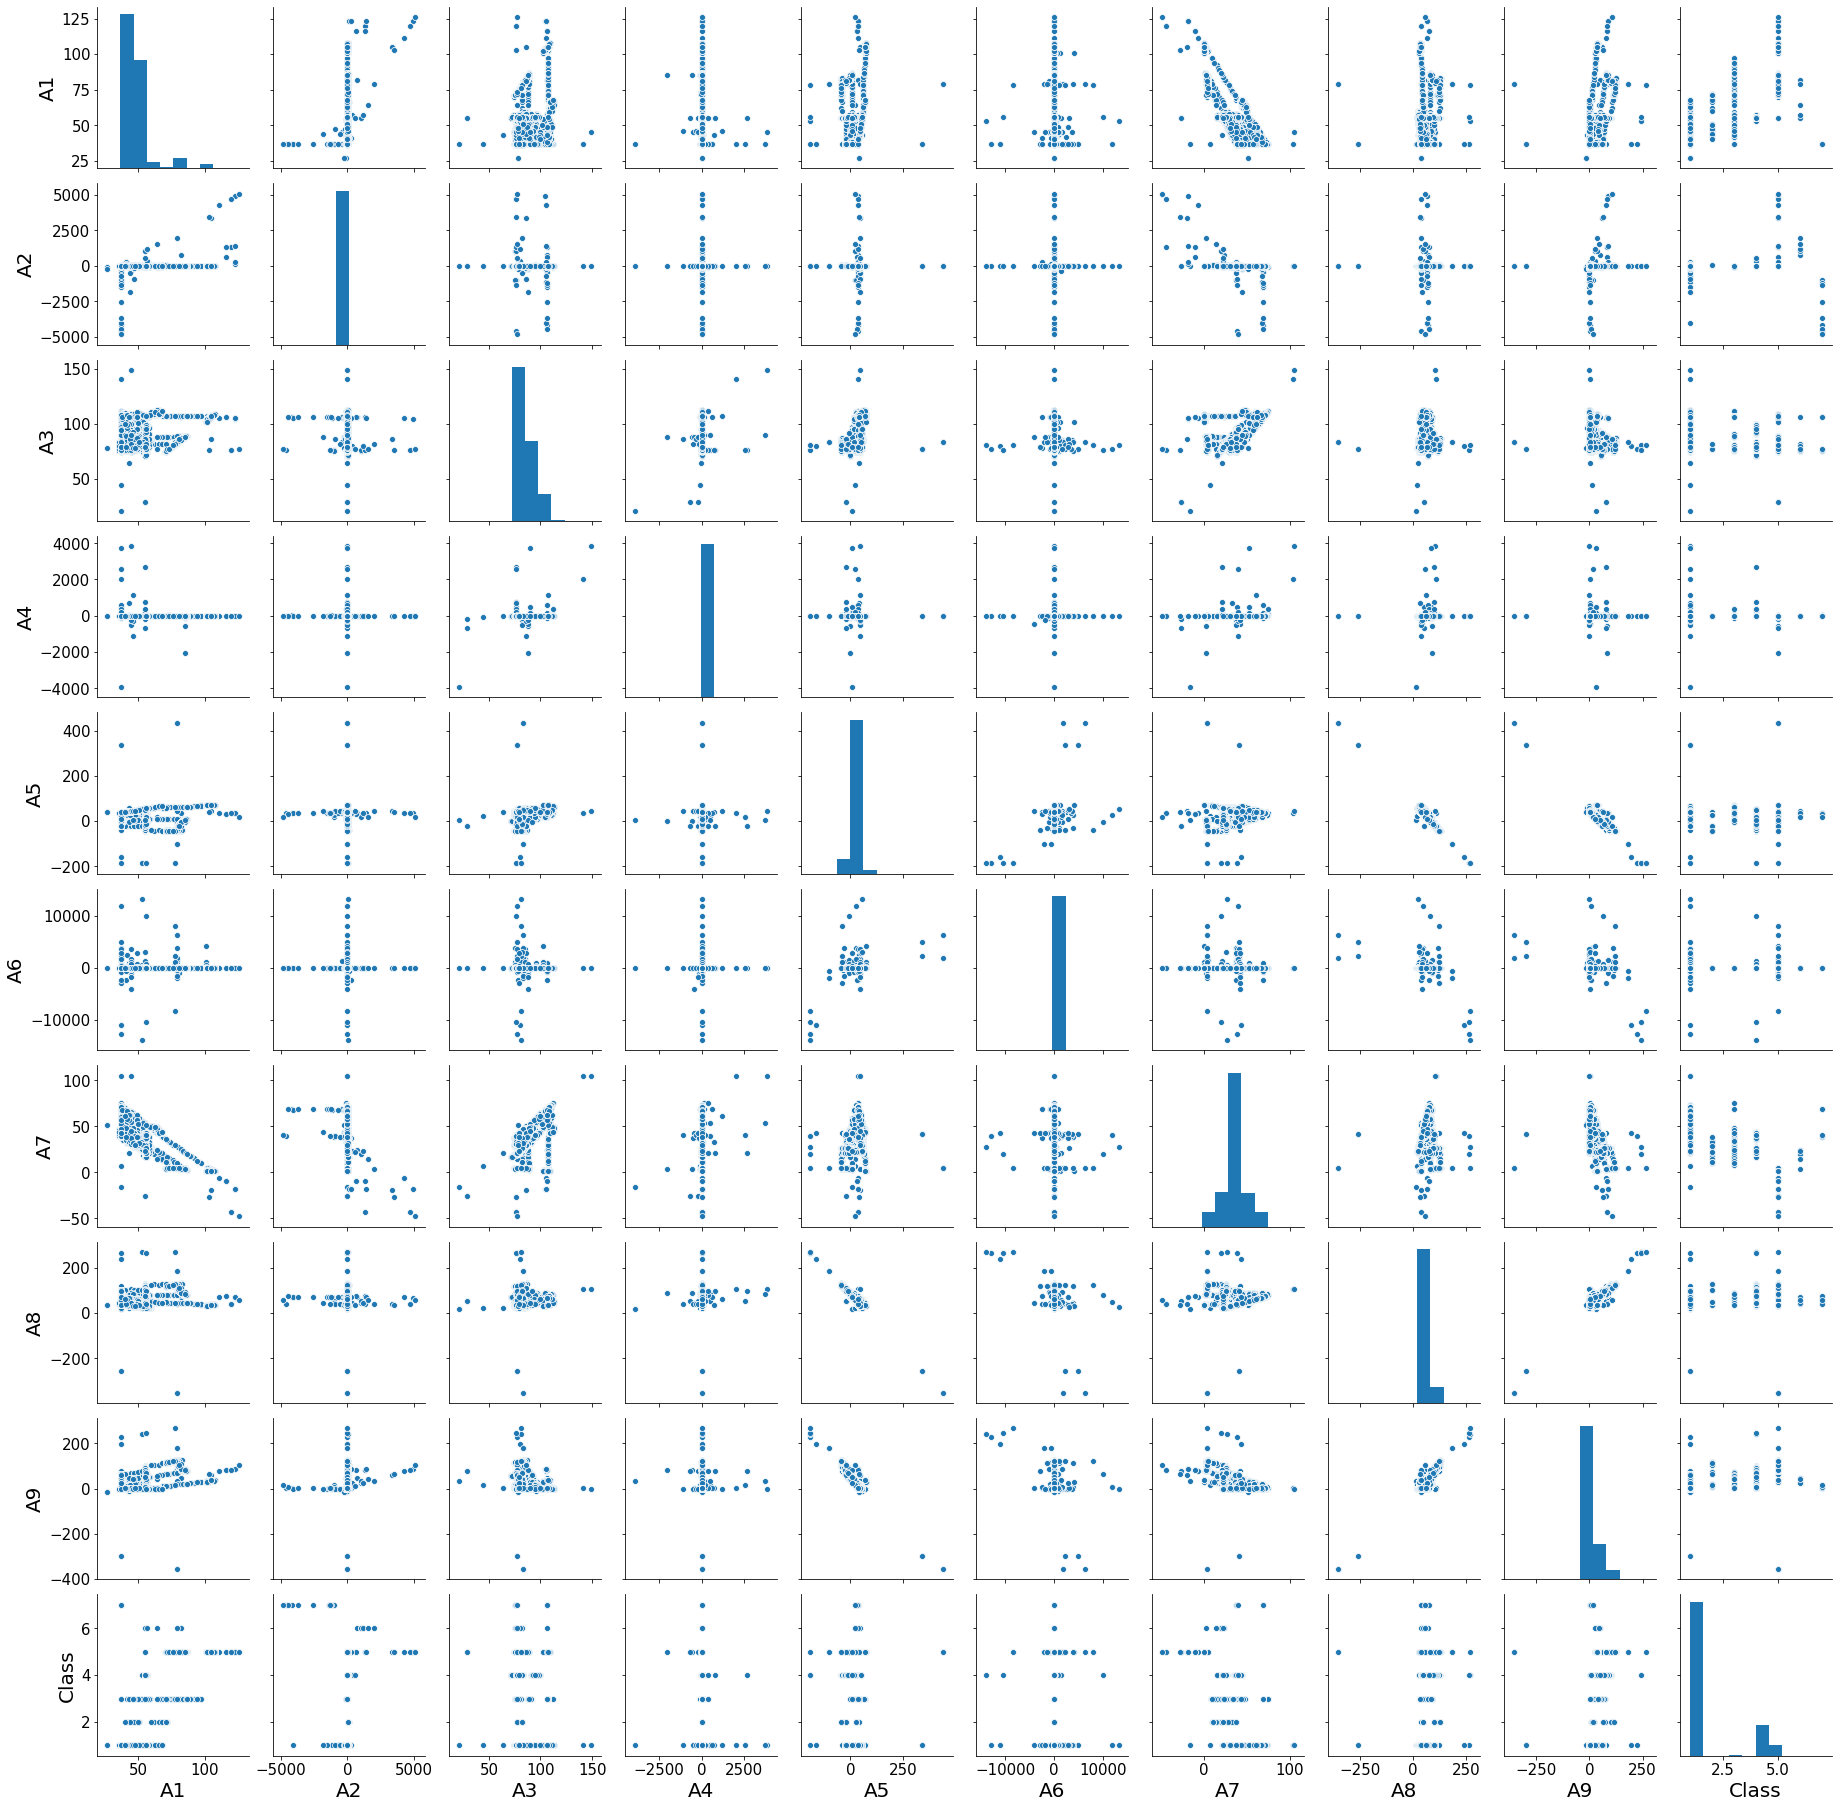

In [6]:
# It takes about 2 minuts to generate pairplot 
g = sns.pairplot(training_data)
g.fig.set_size_inches(25,25)

**Ein Boxplot ist ein weiteres Diagramm, das häufig zur Analyse der Beziehung zwischen einem kategorialen Attribut und einem kontinuierlichen Attribut verwendet wird.**
     
- Die Attribute A4 und A6 sind in jeder Klasse ähnlich verteilt. Das heißt, sie sind nicht klassenbezogen.
- Andere Merkmale haben offensichtlich unterschiedliche Verteilungen auf verschiedene Klassen. Sie sind wichtige Merkmale zur Vorhersage der Klasse!

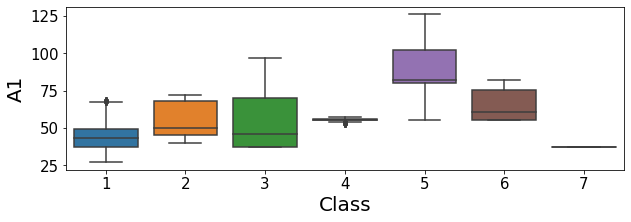

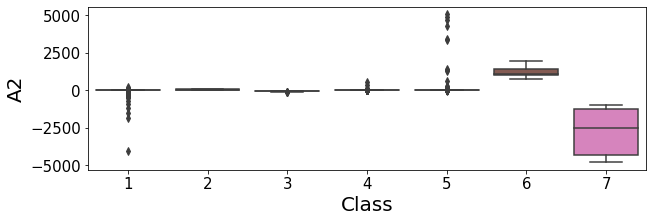

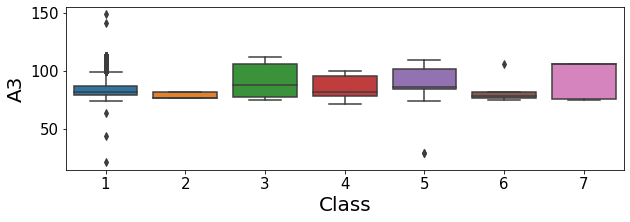

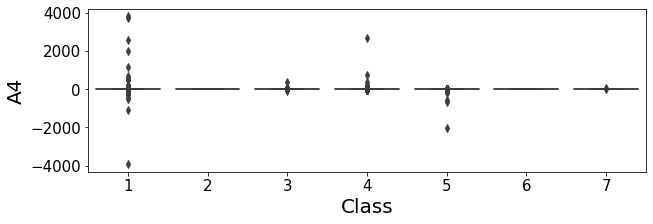

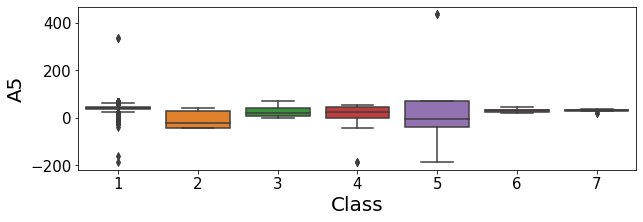

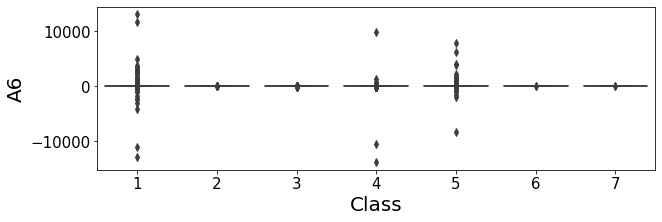

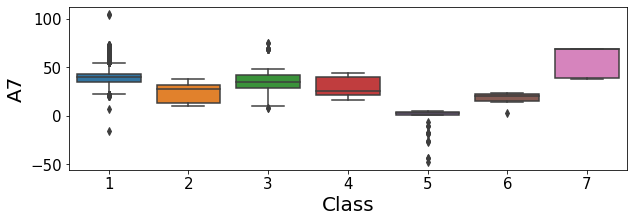

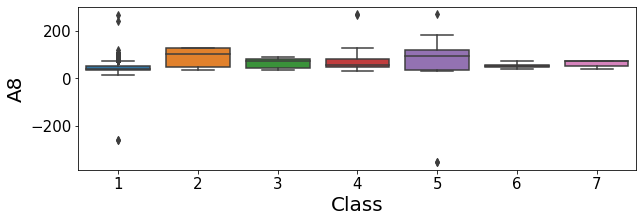

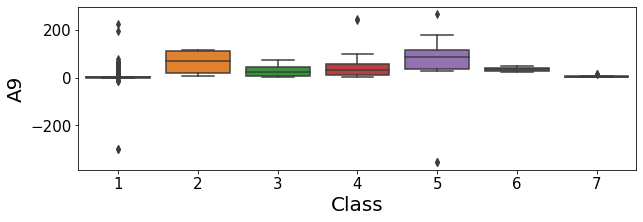

In [7]:
for i in range(9):
    plt.figure(figsize=(10,3))
    sns.boxplot(x="Class", y=training_data.columns[i], data=training_data)
    plt.show()

# 2.) Anomalieerkennung mit überwachtem maschinellen Lernen

**Aufteilung der Test- und Trainingsdaten:**
    
Die Daten sind in 2 Unterdatensätze aufgeteilt. Einer ist ein Trainingsdatensatz, der andere ein Testdatensatz.
- Trainingsdatensatz : Wird zum Training des Modells verwendet.
- Testdatensatz : Wird verwendet, um die Leistung des Modells zu bewerten. Die Daten im Testdatensatz wurden vom Modell nicht "gesehen".

In [8]:
data = training_data.sample(frac=1,random_state=42)
split = int(data.shape[0]*0.8)
train = data.iloc[:split,:]
test = data.iloc[split:,:]

train_y = train["Class"]
train_x = train.drop(columns=["Class"])
test_y = test["Class"]
test_x = test.drop(columns=["Class"])


Der Wertebereich der Daten kann u.U. stark variieren, daher ist ein notwendiger Schritt in der Datenvorverarbeitung die Anwendung einer Normalisierung, um den Wertebereich jedes Attributs zu standardisieren:  

In [9]:
mean_of_train = train_x.mean()
std_of_train = train_x.std()
std_of_train.replace(0, 1, inplace=True)
train_x = (train_x - mean_of_train) / std_of_train
test_x = (test_x - mean_of_train) / std_of_train

Anwendung des **RandomForestClassifier**

In [10]:
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf.fit(train_x, train_y)
y_pred_rf = rf_clf.predict(test_x)

In [11]:

accuracy_rf = accuracy_score(test_y, y_pred_rf)
precision_rf = precision_score(test_y, y_pred_rf, average='macro')
recall_rf = recall_score(test_y, y_pred_rf, average='macro')

print("\nRandomForestClassifier (n_estimators = 500) model metrics are:")
print("Accuracy = {0:.4f}, Precision = {1:.4f} & Recall = {2:.4f}\n".format(accuracy_rf, precision_rf, recall_rf))


RandomForestClassifier (n_estimators = 500) model metrics are:
Accuracy = 0.9994, Precision = 0.9835 & Recall = 0.8695



In [12]:
print(classification_report(test_y, y_pred_rf))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6836
           2       1.00      1.00      1.00         7
           3       0.88      0.92      0.90        25
           4       1.00      1.00      1.00      1367
           5       1.00      1.00      1.00       457
           6       1.00      0.50      0.67         2
           7       1.00      0.67      0.80         6

    accuracy                           1.00      8700
   macro avg       0.98      0.87      0.91      8700
weighted avg       1.00      1.00      1.00      8700



In [13]:
class_names  = ["Rad Flow 1 (normal status)", "Fpv Close 2",
                "Fpv Open 3", "High 4 (normal status)",
                "Bypass 5","Bpv Close 6","Bpv Open 7"]

**Anwendung der Konfusionsmatrix**

Text(0.5, 1.0, 'Confusion matrix, without normalization')

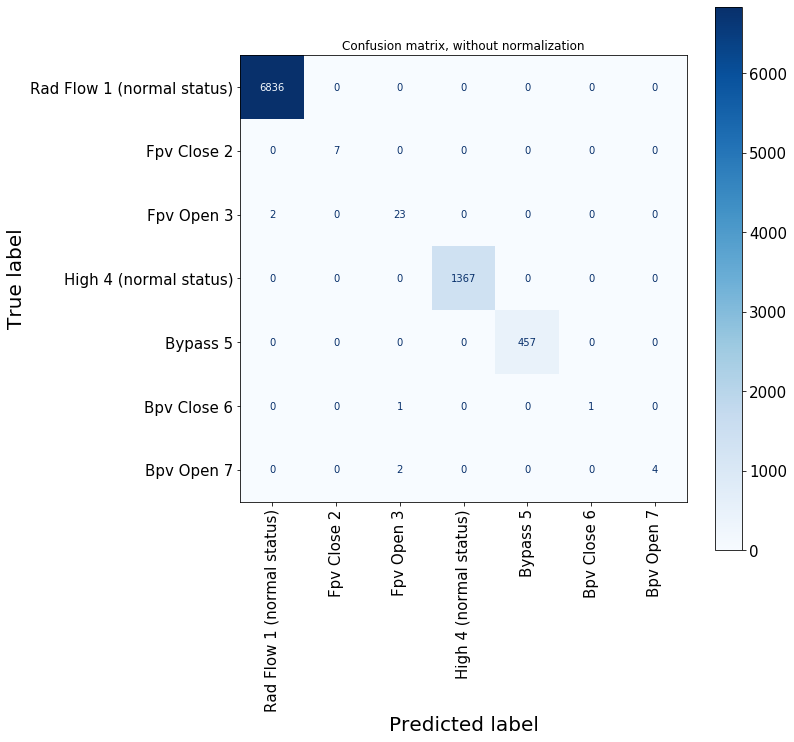

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(rf_clf, test_x, test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
plt.xticks( rotation='vertical')
disp.ax_.set_title("Confusion matrix, without normalization")

**Erkennung wichtiger Merkmale**
    

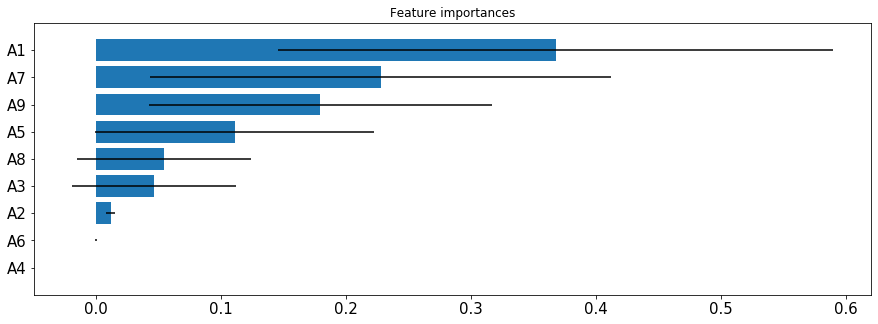

In [15]:

# Die sogenannte Feature Importance lässt sich mittels dem 'RandomForestClassifier' anwenden:
fi_rfc = pd.DataFrame({'feature_importance_scores': rf_clf.feature_importances_, 'attributes': train_col_names[:-1]})
# Sortiert werden soll in absteigender Reihenfolge:
fi_rfc.sort_values('feature_importance_scores', ascending=False, inplace=True)
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)

# Die "Wichtigkeiten" der Features werden sollen nun geplottet werden:
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.barh(range(train_x.shape[1]), importances[indices], xerr=std[indices], align="center")
yticks = [train_col_names[i] for i in indices]
plt.yticks(range(len(indices)),yticks)
plt.ylim([-1, train_x.shape[1]])
plt.show()


Wie bereits angedeutet, sind die Attribute A2 und A4 für Vorhersagen nicht wichtig.

# 3.) Anomalieerkennung mit unüberwachtem maschinellen Lernen 

Aus folgenden Gründen ist es oft unpraktisch oder unmöglich, Anamalien nach festen Regeln oder mit überwachten Methoden des maschinellen Lernens vorherzusagen: 
    
- 1.) Fehlschläge sind zu teuer.
        
Um Daten zu maschinellen Anamalien zu sammeln, werden viele Datensätze durch Run-to-Fail-Experimente gesammelt. Wenn es sich um eine teure Maschine handelt, können die Kosten für eine Anamalie hoch sein.
        
- 2.) Ausfälle sind zu komplex.
        
Geräte sind zu neu, um sowohl den Normal- als auch den Ausfallmodus in einer bestimmten Umgebung angemessen zu charakterisieren, oder die Umgebung ändert sich und versetzt das Gerät in einen unvorhersehbaren Zustand.
        
        

Das Ziel der Anomalieerkennung mit unüberwachtem Lernen ist es, normale und anomale Klassen ohne Verwendung von Label-Informationen erfolgreich zu teilen. Dabei wird im Allgemeinen in zwei Schritten vorgegangen:
    
- 1.) Der erste Schritt besteht in der Charakterisierung eines normalen Basislinienmodells (negative Selektionsalgorithmen, Ein-Klassen-Klassifikatoren und Autoencoder und generative Methoden).
    
- 2.) Der zweite Schritt besteht darin, jeden neuen Datenpunkt als normal oder anomal zu bewerten.
    
    
Im folgenden Notebook zeigen wir die Methode des Agglomerativen Clusterings:


**Einführung: Datensatz**

Um den unüberwachten Lerndatensatz zu bilden, werden die kleinsten fünf Klassen, d.h. 2, 3, 5, 6, 7 zur Anomalieklasse zusammengefasst, während die Klassen 1 und 4 die Normalklasse bilden. (Daten für Klasse 4 werden verworfen)

In [16]:
# Laden des Datensatzes
train_col_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'Class']
training_data = pd.read_csv("./Predictive-Maintenance/Anomaly detection/data/train.csv", index_col=[0],header=[0])
training_data.columns = train_col_names
Anamaly_df = training_data.copy()
#  Klasse 1 und 4 bilden die Normalklasse
Anamaly_df.loc[(Anamaly_df["Class"]==1)| (Anamaly_df["Class"]==4),'Class']=1
#  Klassen 2, 3, 5, 6, 7 werden kombiniert, um die Anomalieklasse zu bilden
Anamaly_df.loc[(Anamaly_df["Class"]!=1),'Class']=2

Anamaly_df["orginal class"] = training_data["Class"]
# Vorverarbeitung: Normalisierung
feature_x = Anamaly_df.drop(columns=["Class","orginal class"])
mean = feature_x.mean()
std = feature_x.std()
std.replace(0, 1, inplace=True)
feature_x = (feature_x - mean) / std

# Labelin
biniary_label = Anamaly_df["Class"]
multi_label = Anamaly_df["orginal class"]

**Es gibt nachfolgend zwei weitere Modelle, Der Unterschied zwischen den Modellen liegt in der definierten Anzahl von Clustern:**

- Wenn die Anzahl der Cluster gleich 7 ist, wird erwartet, dass das Modell automatisch sieben verschiedene Zustände erkennt, ohne die Bezeichnung zu kennen.
- Wenn die Anzahl der Cluster gleich 2 ist, wird erwartet, dass das Modell automatisch zwischen normalen und anormalen Zuständen unterscheidet, ohne die Bezeichnung zu kennen.

**Bildung der Baseline**

In [17]:
Multi_Prediction = pd.Series(1,index=multi_label.index)
accuracy = accuracy_score(multi_label, Multi_Prediction)
print("The baseline (overall accuracy) is : ", accuracy)

from sklearn.metrics import balanced_accuracy_score
balanced_accuracy = balanced_accuracy_score(multi_label, Multi_Prediction)
print("The baseline (balanced accuracy) is ",balanced_accuracy)

The baseline (overall accuracy) is :  0.7840919540229885
The baseline (balanced accuracy) is  0.14285714285714285


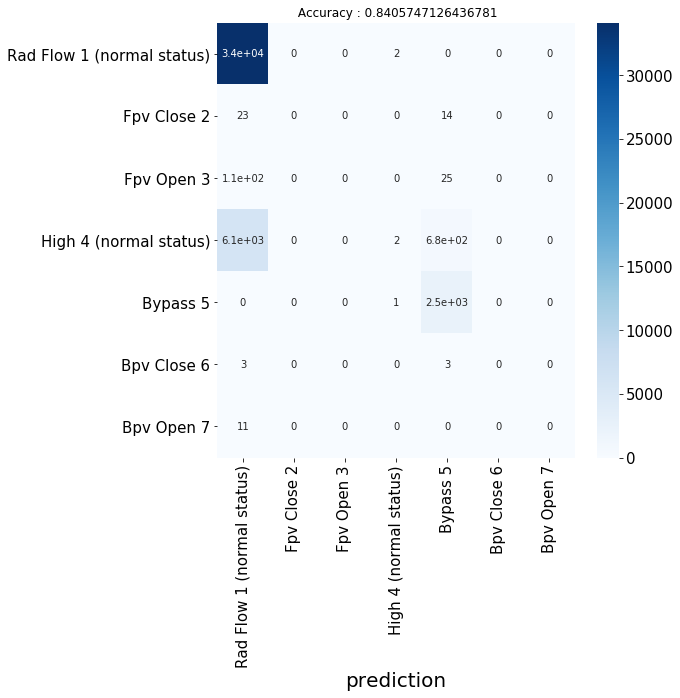

In [18]:
#clustering = AgglomerativeClustering(linkage=linkage, n_clusters=7) # Agglo needs large memory, about 3 GB.
clustering = KMeans(n_clusters = 7)
clustering.fit(feature_x)
Multi_Prediction = pd.Series(np.nan,index=multi_label.index)
# Clustering-Labels könnten vertauscht werden. Daher wählen wir alle Punkte aus jedem Cluster aus 
# und überprüfen deren Etiketten anhand der ursprünglichen Datenetiketten. Daraufhin verwenden wir die dominanten 
# Label für den gesamten Cluster. Im Wesentlichen benennen wir die Cluster um, anstatt die Daten neu zu clustern.
for i in range(7):
    Multi_Prediction[clustering.labels_==i] = multi_label[clustering.labels_==i].value_counts().index[0]
fig, ax = plt.subplots(figsize=(8, 8))
accuracy_rf = accuracy_score(multi_label, Multi_Prediction)
cf_matrix = confusion_matrix(multi_label,Multi_Prediction)
sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues,ax=ax, yticklabels=class_names, xticklabels = class_names, )
plt.xlabel("prediction")
plt.title(" Accuracy : " + str(accuracy_rf))
plt.show()    


**Agglomeratives Clustering mit Cluster = 2**

In [19]:
Multi_Prediction = pd.Series(1,index=multi_label.index)
accuracy = accuracy_score(biniary_label, Multi_Prediction)
print("The baseline is : ", accuracy)


from sklearn.metrics import balanced_accuracy_score
balanced_accuracy = balanced_accuracy_score(biniary_label, Multi_Prediction)
print("The baseline (balanced accuracy) is ",balanced_accuracy)

The baseline is :  0.9392183908045977
The baseline (balanced accuracy) is  0.5


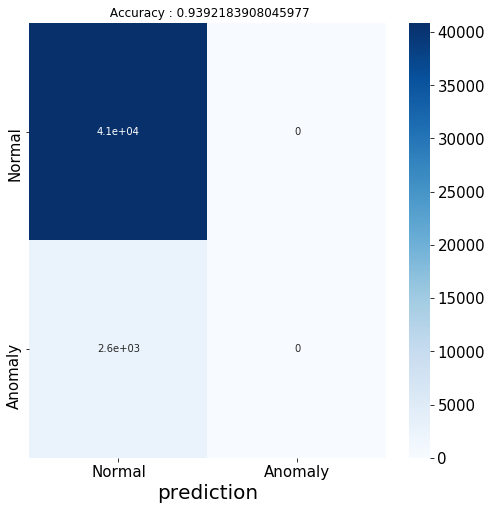

In [21]:
class_names = ["Normal","Anomaly"]

#clustering = AgglomerativeClustering(linkage=linkage, n_clusters=2)
clustering = KMeans(n_clusters = 2)
clustering.fit(feature_x)
Multi_Prediction = pd.Series(np.nan,index=biniary_label.index)
# Clustering-Labels könnten vertauscht werden. Auch hier wählen wir alle Punkte aus jedem Cluster aus 
# und überprüfen deren Etiketten anhand der ursprünglichen Datenetiketten. Dann verwenden wir die dominanten 
# Label für den gesamten Cluster. Auch hier benennen wir die Cluster um, anstatt die Daten neu zu clustern.
for i in range(2):
    Multi_Prediction[clustering.labels_==i] = biniary_label[clustering.labels_==i].value_counts().index[0]
fig, ax = plt.subplots(figsize=(8, 8))
accuracy_rf = accuracy_score(biniary_label, Multi_Prediction)
cf_matrix = confusion_matrix(biniary_label,Multi_Prediction)
sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues,ax=ax, yticklabels=class_names, xticklabels = class_names, )
plt.xlabel("prediction")
plt.title(" Accuracy : " + str(accuracy_rf))
plt.show()    


Im nächsten Notebook wird gezeigt, wie man mit einer Klasse svm und halbüberwachtem maschinellen Lernen mit diesem Problem umgeht, um bessere Ergebnisse zu erzielen.